In [1]:
import numpy as np
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import itertools
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

class FashionCBIR:
    def __init__(self, base_dir, image_size=(224, 224)):
        self.image_size = image_size
        self.base_dir = base_dir
        self.product_database = []
        self.feature_database = None
        self.history = None
        self.label_names = [
            "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
            "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
        ]
        
        # Initialize ResNet50 model
        self.base_model = ResNet50(weights='imagenet', 
                                   include_top=False, 
                                   input_shape=(image_size[0], image_size[1], 3))
        
        # Build feature extractor
        self.model = Sequential([
            self.base_model,
            GlobalAveragePooling2D(),
            Dense(512, activation='relu'),
            Dense(256, activation='relu')
        ])
        
        # Add a classifier on top of the feature extractor for training
        self.classifier = Sequential([
            self.model,
            Dense(10, activation='softmax')  # 10 classes for Fashion MNIST
        ])
        
        # Compile the classifier
        self.classifier.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

    def prepare_fashion_mnist(self):
        """Load and prepare Fashion-MNIST dataset"""
        print("Loading Fashion-MNIST dataset...")
        (self.train_images, self.train_labels), (self.test_images, self.test_labels) = fashion_mnist.load_data()
        
        # Create directories for each category
        for label in self.label_names:
            category_dir = os.path.join(self.base_dir, label.replace("/", "-"))
            os.makedirs(category_dir, exist_ok=True)

        print("Saving training images...")
        self._save_dataset_images(self.train_images, self.train_labels, "train")
        
        print("Saving test images...")
        self._save_dataset_images(self.test_images, self.test_labels, "test")
        
        print(f"Dataset prepared and saved to {self.base_dir}")
        
        # Process images for classifier training
        self.X_train, self.y_train = self._preprocess_dataset_for_training(self.train_images, self.train_labels)
        self.X_test, self.y_test = self._preprocess_dataset_for_training(self.test_images, self.test_labels)

    def _preprocess_dataset_for_training(self, images, labels, sample_size=5000):
        """Preprocess dataset images for training the classifier"""
        if len(images) > sample_size:
            indices = np.random.choice(len(images), sample_size, replace=False)
            images = images[indices]
            labels = labels[indices]
            
        processed_images = []
        for img in images:
            # Convert grayscale to RGB
            img_rgb = np.stack([img] * 3, axis=-1)
            img_resized = tf.image.resize(img_rgb, self.image_size)
            # Preprocess for ResNet50
            img_processed = tf.keras.applications.resnet50.preprocess_input(img_resized)
            processed_images.append(img_processed)
            
        return np.array(processed_images), labels

    def _save_dataset_images(self, images, labels, prefix):
        """Helper function to save dataset images"""
        for i, (image, label) in enumerate(zip(images, labels)):
            img = Image.fromarray(image).convert('RGB')
            img = img.resize(self.image_size)
            
            category = self.label_names[label].replace("/", "-")
            filename = f'{prefix}_image_{i+1}.png'
            save_path = os.path.join(self.base_dir, category, filename)
            img.save(save_path)
            
            product_info = {
                'image_path': save_path,
                'category': category,
                'product_id': f'{prefix}_{i+1}',
                'label_index': label
            }
            self.product_database.append(product_info)
            
            if (i + 1) % 1000 == 0:
                print(f"Processed {i + 1} {prefix} images")

    def preprocess_image(self, image_path):
        """Preprocess image for feature extraction"""
        img = load_img(image_path, target_size=self.image_size)
        img_array = img_to_array(img)
        img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
        return np.expand_dims(img_array, axis=0)

    def train_classifier(self, epochs=10, batch_size=32, validation_split=0.2):
        """Train the classifier model"""
        print("Training classifier...")
        self.history = self.classifier.fit(
            self.X_train, self.y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            verbose=1
        )
        
        # Evaluate the model
        test_loss, test_acc = self.classifier.evaluate(self.X_test, self.y_test, verbose=0)
        print(f"Test accuracy: {test_acc:.4f}")
        
        # Get predictions for confusion matrix and ROC curve
        self.y_pred = np.argmax(self.classifier.predict(self.X_test), axis=1)
        self.y_pred_proba = self.classifier.predict(self.X_test)
        
        return self.history

    def plot_accuracy_loss(self):
        """Plot model accuracy and loss graphs"""
        if self.history is None:
            print("No training history available. Please train the model first.")
            return
            
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot training & validation accuracy
        ax1.plot(self.history.history['accuracy'], 'b-', label='Training Accuracy')
        ax1.plot(self.history.history['val_accuracy'], 'o-', color='orange', label='Validation Accuracy')
        ax1.set_title('Model Accuracy')
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.legend(loc='lower right')
        ax1.grid(True)
        
        # Plot training & validation loss
        ax2.plot(self.history.history['loss'], 'b-', label='Training Loss')
        ax2.plot(self.history.history['val_loss'], 'o-', color='orange', label='Validation Loss')
        ax2.set_title('Model Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.legend(loc='upper right')
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self, normalize=False):
        """Plot confusion matrix"""
        if not hasattr(self, 'y_pred'):
            print("No predictions available. Please train the model first.")
            return
            
        cm = confusion_matrix(self.y_test, self.y_pred)
        
        plt.figure(figsize=(12, 10))
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            title = 'Normalized Confusion Matrix'
        else:
            title = 'Confusion Matrix'
            
        sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', 
                   cmap='Blues', xticklabels=self.label_names, yticklabels=self.label_names)
        
        plt.title(title, fontsize=16)
        plt.ylabel('True label', fontsize=12)
        plt.xlabel('Predicted label', fontsize=12)
        plt.tight_layout()
        plt.show()

    def plot_roc_curve(self):
        """Plot ROC curve for all classes"""
        if not hasattr(self, 'y_pred_proba'):
            print("No prediction probabilities available. Please train the model first.")
            return
            
        n_classes = len(self.label_names)
        
        # Binarize the labels
        y_test_bin = label_binarize(self.y_test, classes=range(n_classes))
        
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], self.y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), self.y_pred_proba.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
        # Compute macro-average ROC curve and ROC area
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
            
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        
        # Plot ROC curves
        plt.figure(figsize=(12, 8))
        
        # Plot micro-average and macro-average ROC curves
        plt.plot(fpr["micro"], tpr["micro"], 
                 label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
                 linestyle=':', linewidth=4)
        
        plt.plot(fpr["macro"], tpr["macro"],
                 label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.2f})',
                 linestyle=':', linewidth=4)
        
        # Plot ROC curves for all classes
        colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan'])
        
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, linewidth=2,
                     label=f'{self.label_names[i]} (AUC = {roc_auc[i]:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
        plt.xlim([-0.01, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('Receiver Operating Characteristic (ROC) Curve for All Classes', fontsize=16)
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()

    def extract_features(self):
        """Extract features for all products in database"""
        print("Extracting features for all products...")
        features = []
        total_products = len(self.product_database)
        
        for i, product in enumerate(self.product_database):
            img_processed = self.preprocess_image(product['image_path'])
            feature_vector = self.model.predict(img_processed, verbose=0)
            features.append(feature_vector.flatten())
            
            if (i + 1) % 1000 == 0:
                print(f"Processed features for {i + 1}/{total_products} products")
        
        self.feature_database = np.array(features)
        print("Feature extraction completed")

    def find_similar_products(self, query_image_path, num_results=10):
        """Find similar products for a given query image"""
        query_processed = self.preprocess_image(query_image_path)
        query_features = self.model.predict(query_processed, verbose=0).flatten()
        
        similarities = cosine_similarity([query_features], self.feature_database)
        similar_indices = np.argsort(similarities[0])[::-1][:num_results]
        
        similar_products = []
        for idx in similar_indices:
            product = self.product_database[idx].copy()
            product['similarity_score'] = similarities[0][idx]
            similar_products.append(product)
        
        return similar_products

    def display_results(self, query_image_path, similar_products):
        """Display query image and similar products"""
        output_dir = '/kaggle/working/'
        num_results = len(similar_products)  # Number of similar products to display
        plt.figure(figsize=(15, 3 + num_results // 5))  # Adjust the figure size
        
        # Display query image
        plt.subplot(1, num_results + 1, 1)
        query_img = load_img(query_image_path, target_size=self.image_size)
        plt.imshow(query_img)
        plt.title('Query Image')
        plt.axis('off')
        
        # Display similar products
        for i, product in enumerate(similar_products):
            plt.subplot(1, num_results + 1, i + 2)
            img = load_img(product['image_path'], target_size=self.image_size)
            plt.imshow(img)
            plt.title(f"Score: {product['similarity_score']:.2f}\n{product['category']}")
            plt.axis('off')

            # Save the result image
            plt.savefig(os.path.join(output_dir, f"similar_product_{i+1}.png"))
        
        plt.tight_layout()
        plt.show()

def main():
    base_dir = '/content/fashion_mnist_images'  # Change this path as needed
    
    # Initialize CBIR system
    cbir = FashionCBIR(base_dir=base_dir)
    
    # Prepare Fashion-MNIST dataset (only needed once)
    print("Step 1: Preparing Fashion-MNIST dataset...")
    cbir.prepare_fashion_mnist()
    
    # Train classifier
    print("\nStep 2: Training classifier...")
    cbir.train_classifier(epochs=10, batch_size=32)
    
    # Plot accuracy and loss graphs
    print("\nStep 3: Plotting accuracy and loss graphs...")
    cbir.plot_accuracy_loss()
    
    # Plot confusion matrix
    print("\nStep 4: Plotting confusion matrix...")
    cbir.plot_confusion_matrix()
    
    # Plot ROC curve
    print("\nStep 5: Plotting ROC curve...")
    cbir.plot_roc_curve()
    
    # Extract features for all products
    print("\nStep 6: Extracting features...")
    cbir.extract_features()
    
    # Example: Find similar products for a query image
    query_image_path = '/kaggle/input/sneaker/sneaker.png'  # Change this path to your query image
    similar_products = cbir.find_similar_products(query_image_path, num_results=10)

    # Display results
    cbir.display_results(query_image_path, similar_products)

if __name__ == "__main__":
    main()

ImportError: cannot import name 'interp' from 'scipy' (/usr/local/lib/python3.10/dist-packages/scipy/__init__.py)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Step 1: Preparing Fashion-MNIST dataset...
Loading Fashion-MNIST dataset...
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Saving training images...
Processed 1000 train images
Processed 2000 train images
Processed 3000 train images
Processed 4000 train images
Processed 5000 train images
Processed 6000 train images
Processed 7000 train images
Processed 8000 train images
Processed 9000 train images
Processed 10000 train images
Processed 11000 train images
Processed 12000 train images
Processed 13000 train images
Processed 14000 train images
Processed 15000 train images
Processed 16000 train images
Processed 17000 train images
Processed 18000 train images
Processed 19000 train images
Processed 20000 train images
Processed 21000 train images
Processed 22000 train images
Processed 23000 train images
P

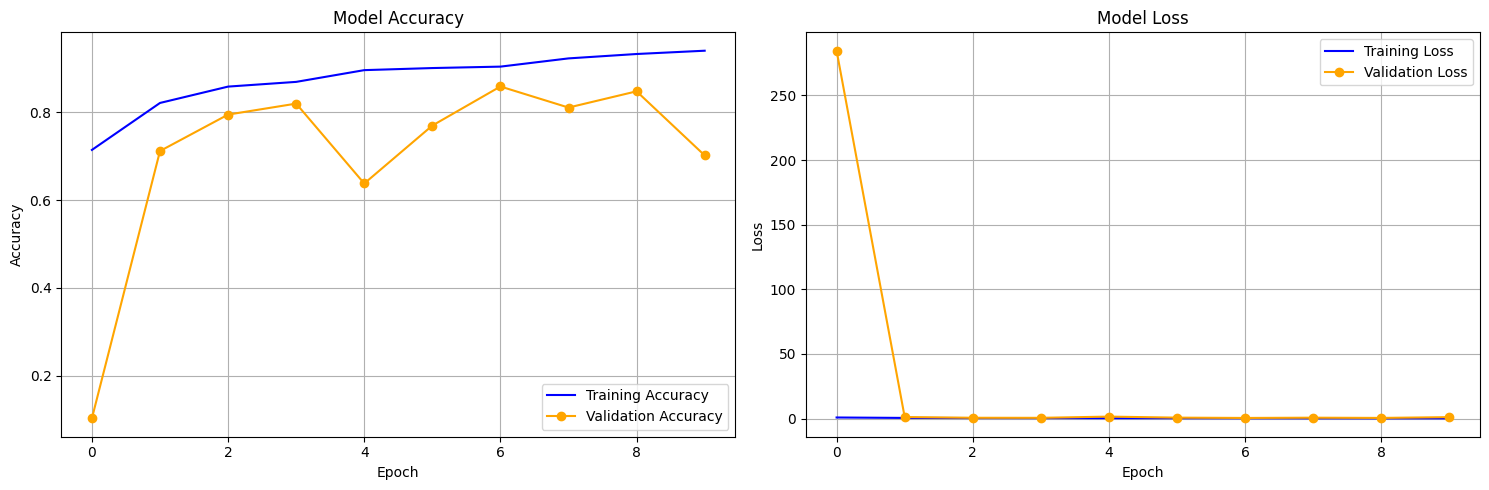


Step 4: Plotting confusion matrix...


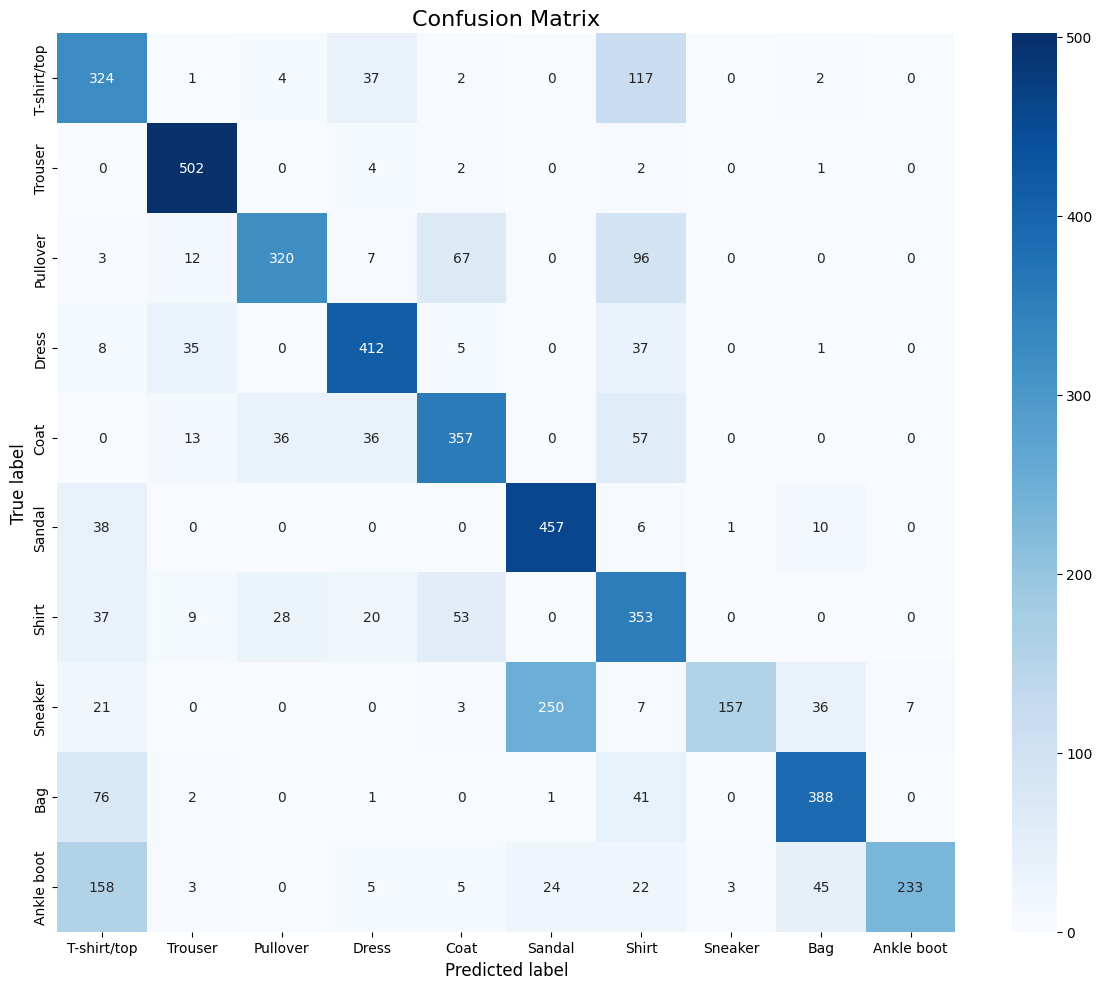


Step 5: Plotting ROC curve...


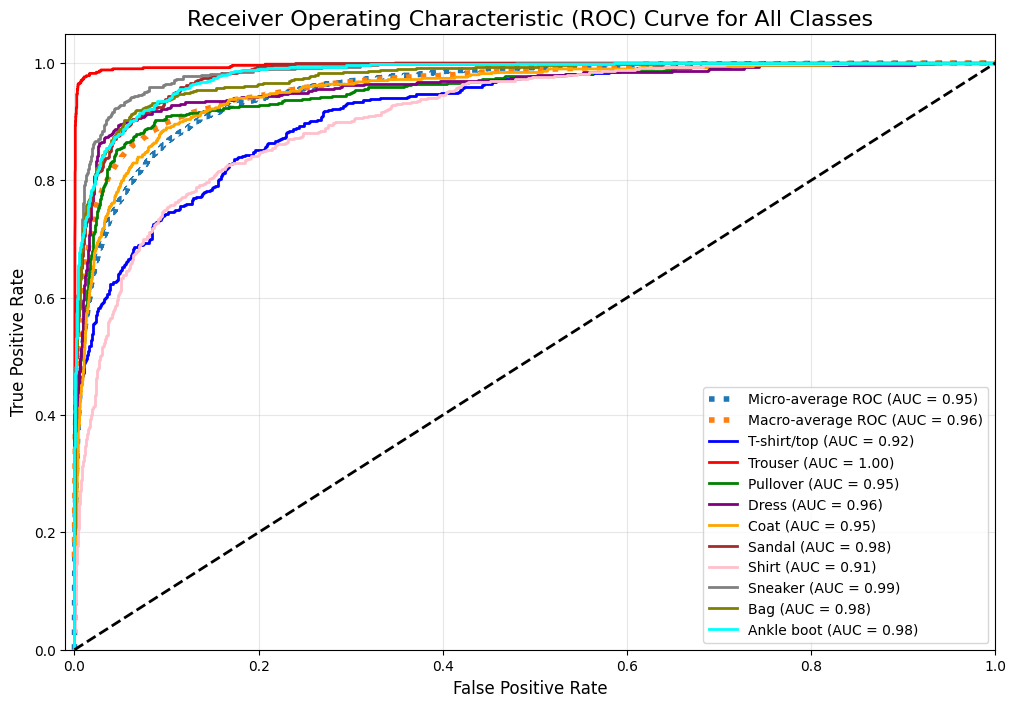


Step 6: Extracting features...
Extracting features for all products...
Processed features for 1000/70000 products
Processed features for 2000/70000 products
Processed features for 3000/70000 products
Processed features for 4000/70000 products
Processed features for 5000/70000 products
Processed features for 6000/70000 products
Processed features for 7000/70000 products
Processed features for 8000/70000 products
Processed features for 9000/70000 products
Processed features for 10000/70000 products
Processed features for 11000/70000 products
Processed features for 12000/70000 products
Processed features for 13000/70000 products
Processed features for 14000/70000 products
Processed features for 15000/70000 products
Processed features for 16000/70000 products
Processed features for 17000/70000 products
Processed features for 18000/70000 products
Processed features for 19000/70000 products
Processed features for 20000/70000 products
Processed features for 21000/70000 products
Processed fea

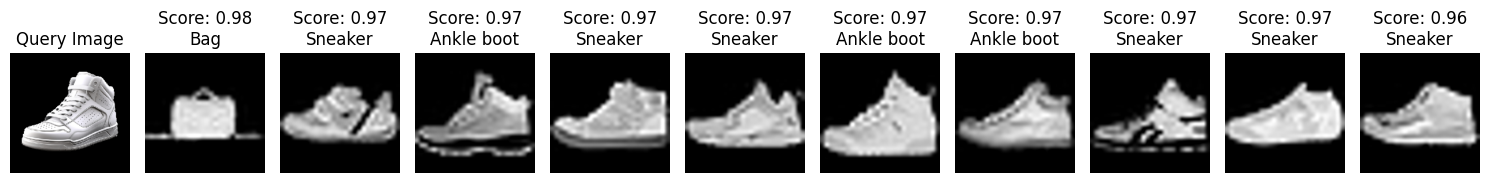

In [2]:
import numpy as np
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import itertools
from sklearn.preprocessing import label_binarize
from itertools import cycle
# Using numpy's interp instead of scipy's interp
from numpy import interp

class FashionCBIR:
    def __init__(self, base_dir, image_size=(224, 224)):
        self.image_size = image_size
        self.base_dir = base_dir
        self.product_database = []
        self.feature_database = None
        self.history = None
        self.label_names = [
            "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
            "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
        ]
        
        # Initialize ResNet50 model
        self.base_model = ResNet50(weights='imagenet', 
                                   include_top=False, 
                                   input_shape=(image_size[0], image_size[1], 3))
        
        # Build feature extractor
        self.model = Sequential([
            self.base_model,
            GlobalAveragePooling2D(),
            Dense(512, activation='relu'),
            Dense(256, activation='relu')
        ])
        
        # Add a classifier on top of the feature extractor for training
        self.classifier = Sequential([
            self.model,
            Dense(10, activation='softmax')  # 10 classes for Fashion MNIST
        ])
        
        # Compile the classifier
        self.classifier.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

    def prepare_fashion_mnist(self):
        """Load and prepare Fashion-MNIST dataset"""
        print("Loading Fashion-MNIST dataset...")
        (self.train_images, self.train_labels), (self.test_images, self.test_labels) = fashion_mnist.load_data()
        
        # Create directories for each category
        for label in self.label_names:
            category_dir = os.path.join(self.base_dir, label.replace("/", "-"))
            os.makedirs(category_dir, exist_ok=True)

        print("Saving training images...")
        self._save_dataset_images(self.train_images, self.train_labels, "train")
        
        print("Saving test images...")
        self._save_dataset_images(self.test_images, self.test_labels, "test")
        
        print(f"Dataset prepared and saved to {self.base_dir}")
        
        # Process images for classifier training
        self.X_train, self.y_train = self._preprocess_dataset_for_training(self.train_images, self.train_labels)
        self.X_test, self.y_test = self._preprocess_dataset_for_training(self.test_images, self.test_labels)

    def _preprocess_dataset_for_training(self, images, labels, sample_size=5000):
        """Preprocess dataset images for training the classifier"""
        if len(images) > sample_size:
            indices = np.random.choice(len(images), sample_size, replace=False)
            images = images[indices]
            labels = labels[indices]
            
        processed_images = []
        for img in images:
            # Convert grayscale to RGB
            img_rgb = np.stack([img] * 3, axis=-1)
            img_resized = tf.image.resize(img_rgb, self.image_size)
            # Preprocess for ResNet50
            img_processed = tf.keras.applications.resnet50.preprocess_input(img_resized)
            processed_images.append(img_processed)
            
        return np.array(processed_images), labels

    def _save_dataset_images(self, images, labels, prefix):
        """Helper function to save dataset images"""
        for i, (image, label) in enumerate(zip(images, labels)):
            img = Image.fromarray(image).convert('RGB')
            img = img.resize(self.image_size)
            
            category = self.label_names[label].replace("/", "-")
            filename = f'{prefix}_image_{i+1}.png'
            save_path = os.path.join(self.base_dir, category, filename)
            img.save(save_path)
            
            product_info = {
                'image_path': save_path,
                'category': category,
                'product_id': f'{prefix}_{i+1}',
                'label_index': label
            }
            self.product_database.append(product_info)
            
            if (i + 1) % 1000 == 0:
                print(f"Processed {i + 1} {prefix} images")

    def preprocess_image(self, image_path):
        """Preprocess image for feature extraction"""
        img = load_img(image_path, target_size=self.image_size)
        img_array = img_to_array(img)
        img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
        return np.expand_dims(img_array, axis=0)

    def train_classifier(self, epochs=10, batch_size=32, validation_split=0.2):
        """Train the classifier model"""
        print("Training classifier...")
        self.history = self.classifier.fit(
            self.X_train, self.y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            verbose=1
        )
        
        # Evaluate the model
        test_loss, test_acc = self.classifier.evaluate(self.X_test, self.y_test, verbose=0)
        print(f"Test accuracy: {test_acc:.4f}")
        
        # Get predictions for confusion matrix and ROC curve
        self.y_pred = np.argmax(self.classifier.predict(self.X_test), axis=1)
        self.y_pred_proba = self.classifier.predict(self.X_test)
        
        return self.history

    def plot_accuracy_loss(self):
        """Plot model accuracy and loss graphs"""
        if self.history is None:
            print("No training history available. Please train the model first.")
            return
            
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot training & validation accuracy
        ax1.plot(self.history.history['accuracy'], 'b-', label='Training Accuracy')
        ax1.plot(self.history.history['val_accuracy'], 'o-', color='orange', label='Validation Accuracy')
        ax1.set_title('Model Accuracy')
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.legend(loc='lower right')
        ax1.grid(True)
        
        # Plot training & validation loss
        ax2.plot(self.history.history['loss'], 'b-', label='Training Loss')
        ax2.plot(self.history.history['val_loss'], 'o-', color='orange', label='Validation Loss')
        ax2.set_title('Model Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.legend(loc='upper right')
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self, normalize=False):
        """Plot confusion matrix"""
        if not hasattr(self, 'y_pred'):
            print("No predictions available. Please train the model first.")
            return
            
        cm = confusion_matrix(self.y_test, self.y_pred)
        
        plt.figure(figsize=(12, 10))
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            title = 'Normalized Confusion Matrix'
        else:
            title = 'Confusion Matrix'
            
        sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', 
                   cmap='Blues', xticklabels=self.label_names, yticklabels=self.label_names)
        
        plt.title(title, fontsize=16)
        plt.ylabel('True label', fontsize=12)
        plt.xlabel('Predicted label', fontsize=12)
        plt.tight_layout()
        plt.show()

    def plot_roc_curve(self):
        """Plot ROC curve for all classes"""
        if not hasattr(self, 'y_pred_proba'):
            print("No prediction probabilities available. Please train the model first.")
            return
            
        n_classes = len(self.label_names)
        
        # Binarize the labels
        y_test_bin = label_binarize(self.y_test, classes=range(n_classes))
        
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], self.y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), self.y_pred_proba.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
        # Compute macro-average ROC curve and ROC area
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
            
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        
        # Plot ROC curves
        plt.figure(figsize=(12, 8))
        
        # Plot micro-average and macro-average ROC curves
        plt.plot(fpr["micro"], tpr["micro"], 
                 label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
                 linestyle=':', linewidth=4)
        
        plt.plot(fpr["macro"], tpr["macro"],
                 label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.2f})',
                 linestyle=':', linewidth=4)
        
        # Plot ROC curves for all classes
        colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan'])
        
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, linewidth=2,
                     label=f'{self.label_names[i]} (AUC = {roc_auc[i]:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
        plt.xlim([-0.01, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('Receiver Operating Characteristic (ROC) Curve for All Classes', fontsize=16)
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()

    def extract_features(self):
        """Extract features for all products in database"""
        print("Extracting features for all products...")
        features = []
        total_products = len(self.product_database)
        
        for i, product in enumerate(self.product_database):
            img_processed = self.preprocess_image(product['image_path'])
            feature_vector = self.model.predict(img_processed, verbose=0)
            features.append(feature_vector.flatten())
            
            if (i + 1) % 1000 == 0:
                print(f"Processed features for {i + 1}/{total_products} products")
        
        self.feature_database = np.array(features)
        print("Feature extraction completed")

    def find_similar_products(self, query_image_path, num_results=10):
        """Find similar products for a given query image"""
        query_processed = self.preprocess_image(query_image_path)
        query_features = self.model.predict(query_processed, verbose=0).flatten()
        
        similarities = cosine_similarity([query_features], self.feature_database)
        similar_indices = np.argsort(similarities[0])[::-1][:num_results]
        
        similar_products = []
        for idx in similar_indices:
            product = self.product_database[idx].copy()
            product['similarity_score'] = similarities[0][idx]
            similar_products.append(product)
        
        return similar_products

    def display_results(self, query_image_path, similar_products):
        """Display query image and similar products"""
        output_dir = '/kaggle/working/'
        num_results = len(similar_products)  # Number of similar products to display
        plt.figure(figsize=(15, 3 + num_results // 5))  # Adjust the figure size
        
        # Display query image
        plt.subplot(1, num_results + 1, 1)
        query_img = load_img(query_image_path, target_size=self.image_size)
        plt.imshow(query_img)
        plt.title('Query Image')
        plt.axis('off')
        
        # Display similar products
        for i, product in enumerate(similar_products):
            plt.subplot(1, num_results + 1, i + 2)
            img = load_img(product['image_path'], target_size=self.image_size)
            plt.imshow(img)
            plt.title(f"Score: {product['similarity_score']:.2f}\n{product['category']}")
            plt.axis('off')

            # Save the result image
            plt.savefig(os.path.join(output_dir, f"similar_product_{i+1}.png"))
        
        plt.tight_layout()
        plt.show()

def main():
    base_dir = '/content/fashion_mnist_images'  # Change this path as needed
    
    # Initialize CBIR system
    cbir = FashionCBIR(base_dir=base_dir)
    
    # Prepare Fashion-MNIST dataset (only needed once)
    print("Step 1: Preparing Fashion-MNIST dataset...")
    cbir.prepare_fashion_mnist()
    
    # Train classifier
    print("\nStep 2: Training classifier...")
    cbir.train_classifier(epochs=10, batch_size=32)
    
    # Plot accuracy and loss graphs
    print("\nStep 3: Plotting accuracy and loss graphs...")
    cbir.plot_accuracy_loss()
    
    # Plot confusion matrix
    print("\nStep 4: Plotting confusion matrix...")
    cbir.plot_confusion_matrix()
    
    # Plot ROC curve
    print("\nStep 5: Plotting ROC curve...")
    cbir.plot_roc_curve()
    
    # Extract features for all products
    print("\nStep 6: Extracting features...")
    cbir.extract_features()
    
    # Example: Find similar products for a query image
    query_image_path = '/kaggle/input/sneaker/sneaker.png'  # Change this path to your query image
    similar_products = cbir.find_similar_products(query_image_path, num_results=10)

    # Display results
    cbir.display_results(query_image_path, similar_products)

if __name__ == "__main__":
    main()